In [64]:
import os
from ast import literal_eval
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mlflow.metrics import r2_score
from phik import phik_matrix
import mlflow
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

sns.set_theme(style='white')
sns.set_theme(rc={'axes.facecolor':'#FFEFD5','figure.facecolor':'#FFEFD5'})
sns.set_context('poster',font_scale = .7)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'DejaVu Sans'

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#F9A602', '#9B59B6', '#E74C3C']

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

DATA_DIR = Path().resolve().parent / 'data'

In [2]:
def check_df(dataframe, head=5):
    print('SHAPE'.center(70,'-'))
    print(dataframe.shape)
    print('HEAD'.center(70,'-'))
    print(dataframe.head(head))
    print('INFO'.center(70,'-'))
    print(dataframe.info())
    print('NUNIQUE'.center(70,'-'))
    print(dataframe.nunique())
    print('MISSING VALUES'.center(70,'-'))
    print(dataframe.isnull().sum())
    print('DUPLICATED ROWS'.center(70,'-'))
    print(dataframe.duplicated().sum())


def plot_numeric_col(data, column, bins=30, figsize=(16, 8)):
    """
    –°–æ–∑–¥–∞–µ—Ç –∫–æ–º–ø–ª–µ–∫—Å–Ω—ã–π –≥—Ä–∞—Ñ–∏–∫ –¥–ª—è –∫–æ–ª–∏—á–µ—Å—Ç–≤–µ–Ω–Ω–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π
    """
    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1])

    # –ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ —Å KDE
    ax1 = plt.subplot(gs[0, :])
    sns.histplot(data=data, x=column, bins=bins, kde=True,
                color=colors[0], alpha=0.7, ax=ax1)
    ax1.axvline(data[column].mean(), color='red', linestyle='--',
               label=f'Mean: {data[column].mean():.2f}')
    ax1.axvline(data[column].median(), color='green', linestyle='--',
               label=f'Median: {data[column].median():.2f}')
    ax1.set_title(f'Distribution of {column}', fontsize=16, fontweight='bold')
    ax1.set_xlabel(column, fontsize=14)
    ax1.set_ylabel('Frequency', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Boxplot
    ax2 = plt.subplot(gs[1, 0])
    sns.boxplot(x=data[column], color=colors[1], ax=ax2)
    ax2.set_title(f'Boxplot of {column}', fontsize=14)
    ax2.set_xlabel(column, fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Violin plot
    ax3 = plt.subplot(gs[1, 1])
    sns.violinplot(x=data[column], color=colors[2], ax=ax3)
    ax3.set_title(f'Violin Plot of {column}', fontsize=14)
    ax3.set_xlabel(column, fontsize=12)
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_categorical_col(data, column, top_n=10, figsize=(16, 8)):
    """
    –ö–æ–º–ø–ª–µ–∫—Å–Ω—ã–π –≥—Ä–∞—Ñ–∏–∫ –¥–ª—è –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π
    """
    # –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö
    value_counts = data[column].value_counts()
    if len(value_counts) > top_n:
        top_categories = value_counts.head(top_n)
        other_count = value_counts[top_n:].sum()
        top_categories['Other'] = other_count
    else:
        top_categories = value_counts

    # –°–æ–∑–¥–∞–Ω–∏–µ subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # –°—Ç–æ–ª–±—á–∞—Ç–∞—è –¥–∏–∞–≥—Ä–∞–º–º–∞
    bars = ax1.bar(range(len(top_categories)), top_categories.values,
                  color=colors[:len(top_categories)], alpha=0.8)
    ax1.set_title(f'Bar Chart of {column}', fontsize=16, fontweight='bold')
    ax1.set_xlabel(column, fontsize=14)
    ax1.set_ylabel('Count', fontsize=14)
    ax1.set_xticks(range(len(top_categories)))
    ax1.set_xticklabels(top_categories.index, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)

    # –î–æ–±–∞–≤–ª–µ–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏–π –Ω–∞ —Å—Ç–æ–ª–±—Ü—ã
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:,}', ha='center', va='bottom', fontsize=10)

    # –ö—Ä—É–≥–æ–≤–∞—è –¥–∏–∞–≥—Ä–∞–º–º–∞
    wedges, texts, autotexts = ax2.pie(top_categories.values,
                                      labels=top_categories.index,
                                      autopct='%1.1f%%',
                                      colors=colors[:len(top_categories)],
                                      startangle=90)
    ax2.set_title(f'Pie Chart of {column}', fontsize=16, fontweight='bold')

    # –£–ª—É—á—à–µ–Ω–∏–µ —á–∏—Ç–∞–µ–º–æ—Å—Ç–∏
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)

    plt.tight_layout()
    plt.show()

## –ó–∞–≥—Ä—É–∑–∫–∞ –∏ –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö

In [3]:
df = pd.read_csv(DATA_DIR / 'Spb_flats_prices.csv')
check_df(df)

--------------------------------SHAPE---------------------------------
(1080, 9)
---------------------------------HEAD---------------------------------
                                   Underground Times  \
0  {'Underground name': ['–ë–∞–ª—Ç–∏–π—Å–∫–∞—è', '–í–∞—Å–∏–ª–µ–æ—Å—Ç...   
1  {'Underground name': ['–ú–æ—Å–∫–æ–≤—Å–∫–∞—è', '–ë—É—Ö–∞—Ä–µ—Å—Ç—Å...   
2  {'Underground name': ['–í–∞—Å–∏–ª–µ–æ—Å—Ç—Ä–æ–≤—Å–∫–∞—è', '–°–ø–æ...   
3  {'Underground name': ['–£–ª–∏—Ü–∞ –î—ã–±–µ–Ω–∫–æ', '–ü—Ä–æ—Å–ø–µ...   
4  {'Underground name': ['–î–µ–≤—è—Ç–∫–∏–Ω–æ', '–ì—Ä–∞–∂–¥–∞–Ω—Å–∫–∏...   

   Flat Status (1 - handed over, 0 - not handed over) Flat Type  \
0                                                  1     4-–∫–æ–º–Ω   
1                                                  1     2-–∫–æ–º–Ω   
2                                                  0     3-–∫–æ–º–Ω   
3                                                  1     2-–∫–æ–º–Ω   
4                                                  1     1-–∫–æ–º–

In [4]:
df.columns = ['metro_info',
             'flat_status',
             'num_of_rooms',
             'total_area_m2',
             'living_area_m2',
             'kitchen_area_m2',
             'floor',
             'year_of_bulding',
             'price']

In [5]:
def nearest_metro_station(json):
    stations_dict = literal_eval(json)

    nearest_station = stations_dict['Underground name'][0]
    time_to_get = stations_dict['Underground time'][0]
    way_to_get_to = stations_dict['Transport type'][0]

    return [nearest_station, time_to_get, way_to_get_to]

In [6]:
df[['metro_station',
    'minutes_to_metro',
    'transfer_type']] = pd.DataFrame(df['metro_info'].apply(lambda x: nearest_metro_station(x)).tolist(),
                                     index=df.index)
df.drop('metro_info', axis=1, inplace=True)

In [7]:
df['num_of_rooms'].unique()

array(['4-–∫–æ–º–Ω', '2-–∫–æ–º–Ω', '3-–∫–æ–º–Ω', '1-–∫–æ–º–Ω', '5-–∫–æ–º–Ω', '–°—Ç—É–¥–∏—è',
       '–ú–Ω–æ–≥–æ–∫–æ–º–Ω–∞—Ç–Ω—ã', '–ú–Ω–æ–≥–æ–∫–æ–º–Ω–∞—Ç–Ω–∞', '–ê–ø–∞—Ä—Ç–∞–º–µ–Ω—Ç—ã-—Å—Ç—É–¥–∏—è', '15/4',
       '–ö–≤–∞—Ä—Ç–∏—Ä', '29/4'], dtype=object)

In [8]:
df['num_of_rooms'] = df['num_of_rooms'].apply(lambda x: '–ù–µ–∏–∑–≤–µ—Å—Ç–Ω–æ' if x in ['–ú–Ω–æ–≥–æ–∫–æ–º–Ω–∞—Ç–Ω—ã',
                                                                          '–ú–Ω–æ–≥–æ–∫–æ–º–Ω–∞—Ç–Ω–∞',
                                                                          '15/4',
                                                                          '–ö–≤–∞—Ä—Ç–∏—Ä',
                                                                          '29/4'] else x)

In [9]:
replacements = {
    '–ê–ø–∞—Ä—Ç–∞–º–µ–Ω—Ç—ã-—Å—Ç—É–¥–∏—è': '–°—Ç—É–¥–∏—è',
    '1-–∫–æ–º–Ω': '1-–∫–æ–º–Ω–∞—Ç–Ω–∞—è'
}
df['num_of_rooms'] = df['num_of_rooms'].replace('–ê–ø–∞—Ä—Ç–∞–º–µ–Ω—Ç—ã-—Å—Ç—É–¥–∏—è', '–°—Ç—É–¥–∏—è')

In [10]:
df['num_of_rooms'] = df['num_of_rooms'].apply(lambda x: x + '–∞—Ç–Ω–∞—è' if x not in ['–°—Ç—É–¥–∏—è', '–ù–µ–∏–∑–≤–µ—Å—Ç–Ω–æ'] else x)

In [11]:
df['num_of_rooms'].unique()

array(['4-–∫–æ–º–Ω–∞—Ç–Ω–∞—è', '2-–∫–æ–º–Ω–∞—Ç–Ω–∞—è', '3-–∫–æ–º–Ω–∞—Ç–Ω–∞—è', '1-–∫–æ–º–Ω–∞—Ç–Ω–∞—è',
       '5-–∫–æ–º–Ω–∞—Ç–Ω–∞—è', '–°—Ç—É–¥–∏—è', '–ù–µ–∏–∑–≤–µ—Å—Ç–Ω–æ'], dtype=object)

In [12]:
df.duplicated().sum()

np.int64(82)

In [13]:
current_year = datetime.now().year
df['house_age'] = (current_year - df['year_of_bulding']).apply(lambda x: x if x > 0 else 0)

In [14]:
df['is_future_building'] = (df['year_of_bulding'] > current_year).astype(int)
df.drop('year_of_bulding', axis=1, inplace=True)

In [15]:
df.head()

flat_status num_of_rooms  total_area_m2  living_area_m2  kitchen_area_m2  \
0            1  4-–∫–æ–º–Ω–∞—Ç–Ω–∞—è         125.50            75.8             22.9   
1            1  2-–∫–æ–º–Ω–∞—Ç–Ω–∞—è          41.50            26.4              6.0   
2            0  3-–∫–æ–º–Ω–∞—Ç–Ω–∞—è          80.39            44.9             10.2   
3            1  2-–∫–æ–º–Ω–∞—Ç–Ω–∞—è          65.10            27.0             19.0   
4            1  1-–∫–æ–º–Ω–∞—Ç–Ω–∞—è          38.50            16.6             10.5   

   floor     price     metro_station minutes_to_metro transfer_type  \
0      4  24500000        –ë–∞–ª—Ç–∏–π—Å–∫–∞—è                5           car   
1      3   6300000        –ú–æ—Å–∫–æ–≤—Å–∫–∞—è                6           car   
2      3  30061520  –í–∞—Å–∏–ª–µ–æ—Å—Ç—Ä–æ–≤—Å–∫–∞—è               11          legs   
3      4  11500000     –£–ª–∏—Ü–∞ –î—ã–±–µ–Ω–∫–æ                7           car   
4     10   5599000         –î–µ–≤—è—Ç–∫–∏–Ω–æ                6           car   

   house_age  is_future_building  
0        149                   0  
1         61                   0  
2          0                   0  
3         42                   0  
4         10                   0

In [16]:
df['minutes_to_metro'] = df['minutes_to_metro'].replace('–æ—Ç–∫—Ä–æ–µ—Ç—Å—è', 10).astype(int)

In [17]:
check_df(df)

--------------------------------SHAPE---------------------------------
(1080, 12)
---------------------------------HEAD---------------------------------
   flat_status num_of_rooms  total_area_m2  living_area_m2  kitchen_area_m2  \
0            1  4-–∫–æ–º–Ω–∞—Ç–Ω–∞—è         125.50            75.8             22.9   
1            1  2-–∫–æ–º–Ω–∞—Ç–Ω–∞—è          41.50            26.4              6.0   
2            0  3-–∫–æ–º–Ω–∞—Ç–Ω–∞—è          80.39            44.9             10.2   
3            1  2-–∫–æ–º–Ω–∞—Ç–Ω–∞—è          65.10            27.0             19.0   
4            1  1-–∫–æ–º–Ω–∞—Ç–Ω–∞—è          38.50            16.6             10.5   

   floor     price     metro_station  minutes_to_metro transfer_type  \
0      4  24500000        –ë–∞–ª—Ç–∏–π—Å–∫–∞—è                 5           car   
1      3   6300000        –ú–æ—Å–∫–æ–≤—Å–∫–∞—è                 6           car   
2      3  30061520  –í–∞—Å–∏–ª–µ–æ—Å—Ç—Ä–æ–≤—Å–∫–∞—è                11          legs   
3  

In [18]:
df.drop_duplicates(inplace=True)

## EDA

In [19]:
df.head()

flat_status num_of_rooms  total_area_m2  living_area_m2  kitchen_area_m2  \
0            1  4-–∫–æ–º–Ω–∞—Ç–Ω–∞—è         125.50            75.8             22.9   
1            1  2-–∫–æ–º–Ω–∞—Ç–Ω–∞—è          41.50            26.4              6.0   
2            0  3-–∫–æ–º–Ω–∞—Ç–Ω–∞—è          80.39            44.9             10.2   
3            1  2-–∫–æ–º–Ω–∞—Ç–Ω–∞—è          65.10            27.0             19.0   
4            1  1-–∫–æ–º–Ω–∞—Ç–Ω–∞—è          38.50            16.6             10.5   

   floor     price     metro_station  minutes_to_metro transfer_type  \
0      4  24500000        –ë–∞–ª—Ç–∏–π—Å–∫–∞—è                 5           car   
1      3   6300000        –ú–æ—Å–∫–æ–≤—Å–∫–∞—è                 6           car   
2      3  30061520  –í–∞—Å–∏–ª–µ–æ—Å—Ç—Ä–æ–≤—Å–∫–∞—è                11          legs   
3      4  11500000     –£–ª–∏—Ü–∞ –î—ã–±–µ–Ω–∫–æ                 7           car   
4     10   5599000         –î–µ–≤—è—Ç–∫–∏–Ω–æ                 6           car   

   house_age  is_future_building  
0        149                   0  
1         61                   0  
2          0                   0  
3         42                   0  
4         10                   0

In [20]:
shape_before_eda = df.shape

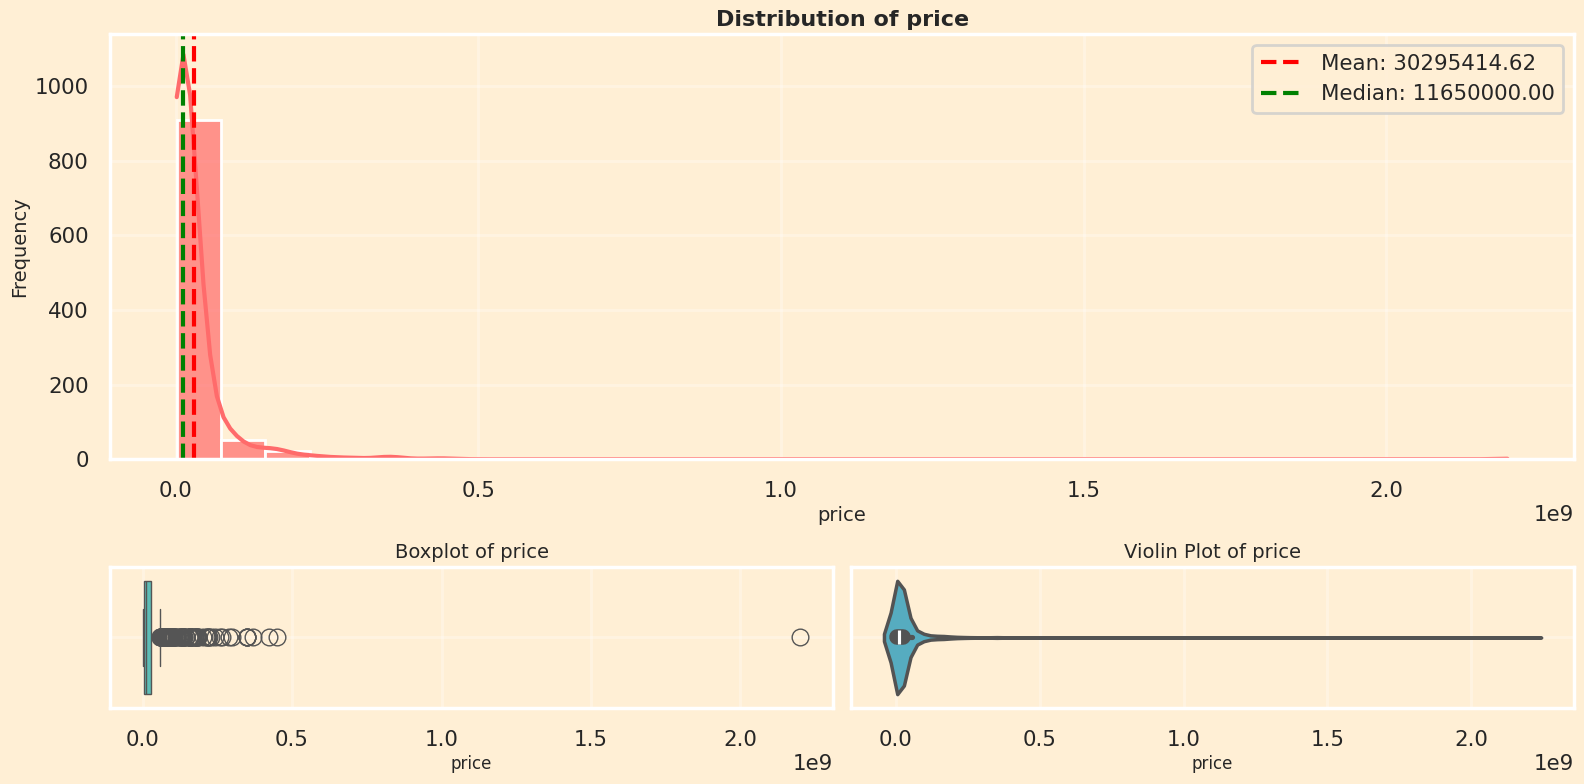

In [21]:
plot_numeric_col(df, 'price')

In [22]:
df = df[df['price'] < 75000000]

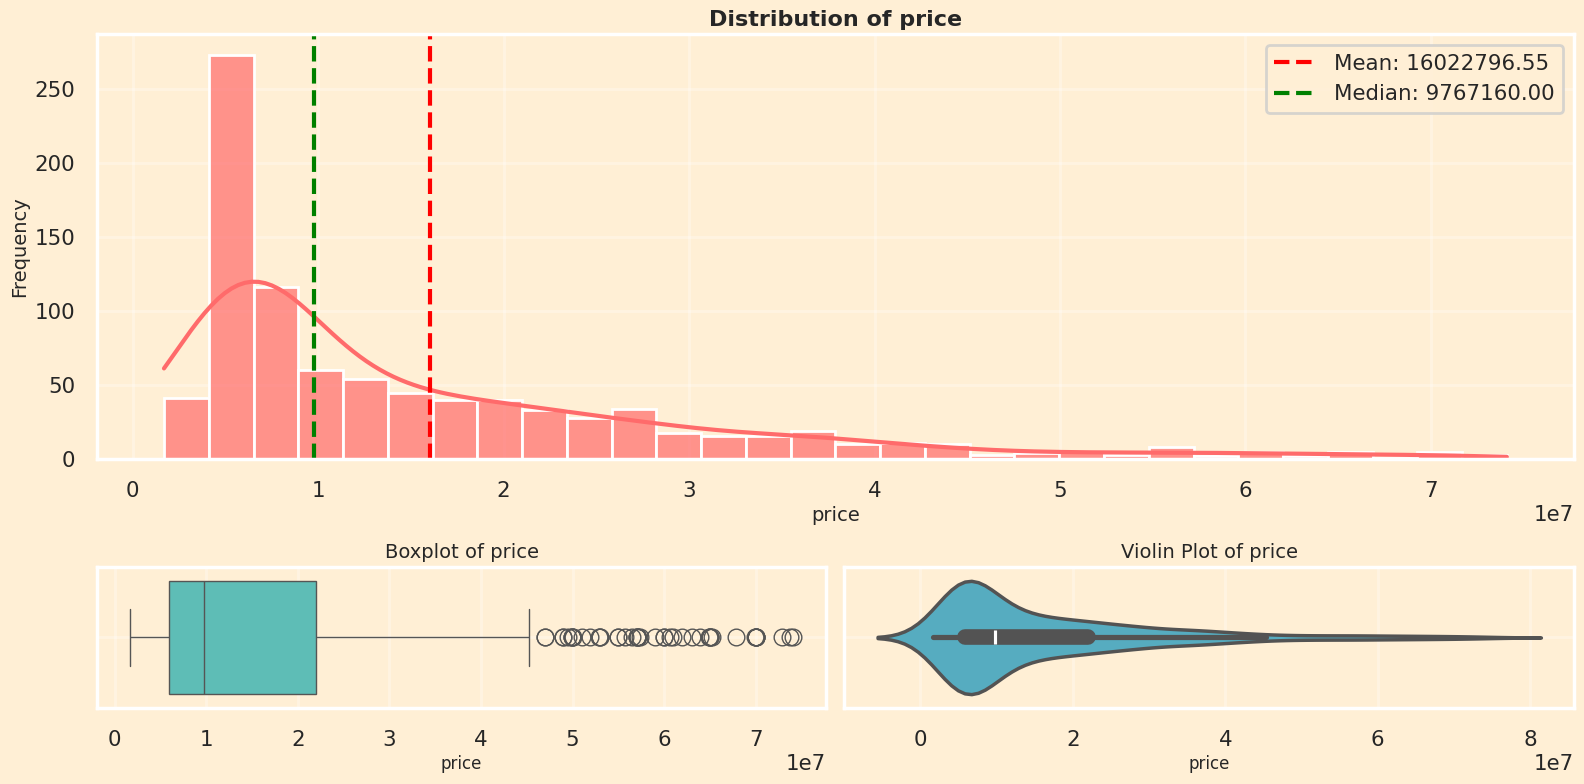

In [23]:
plot_numeric_col(df, 'price')

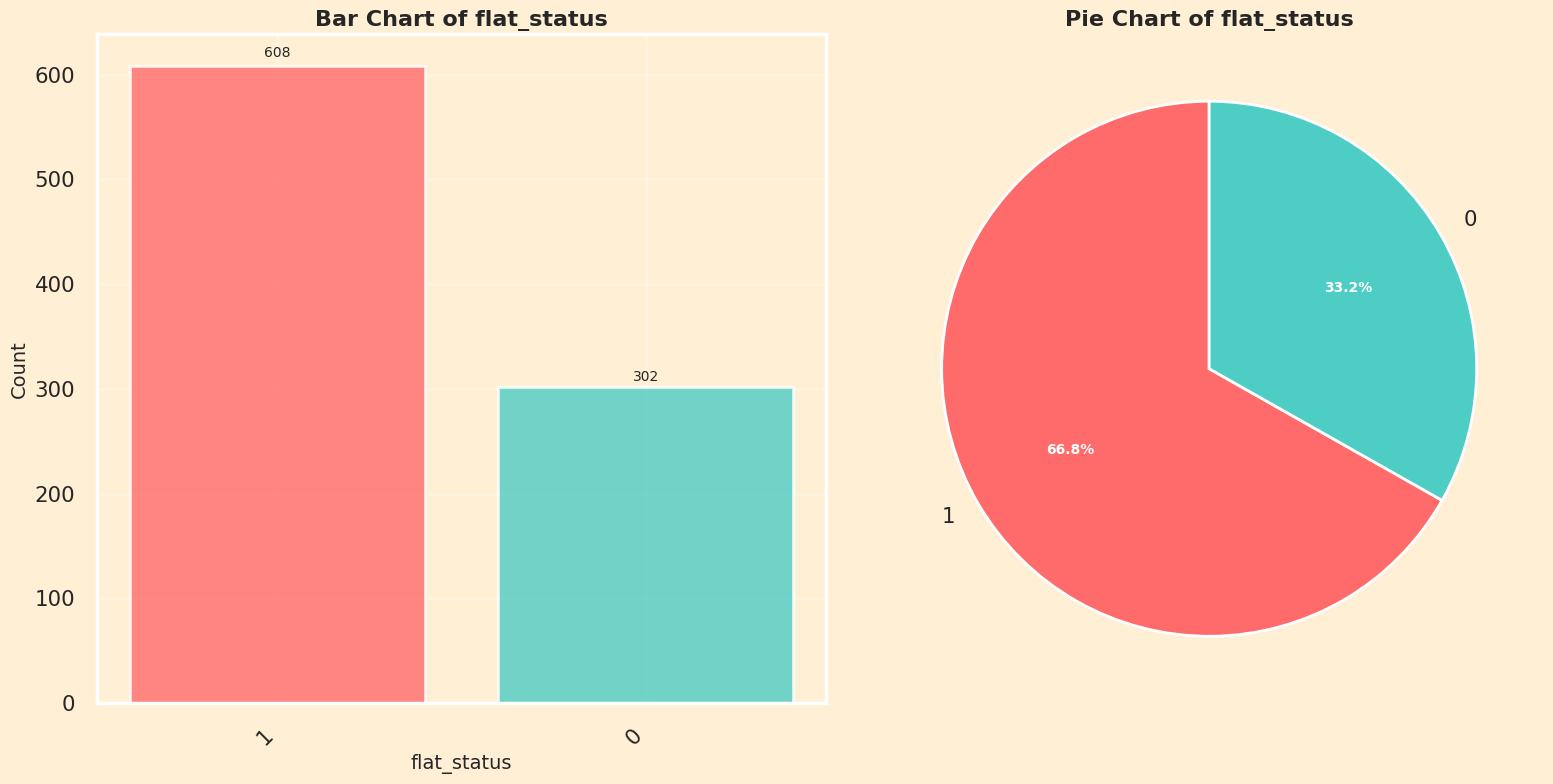

In [24]:
plot_categorical_col(df, 'flat_status')

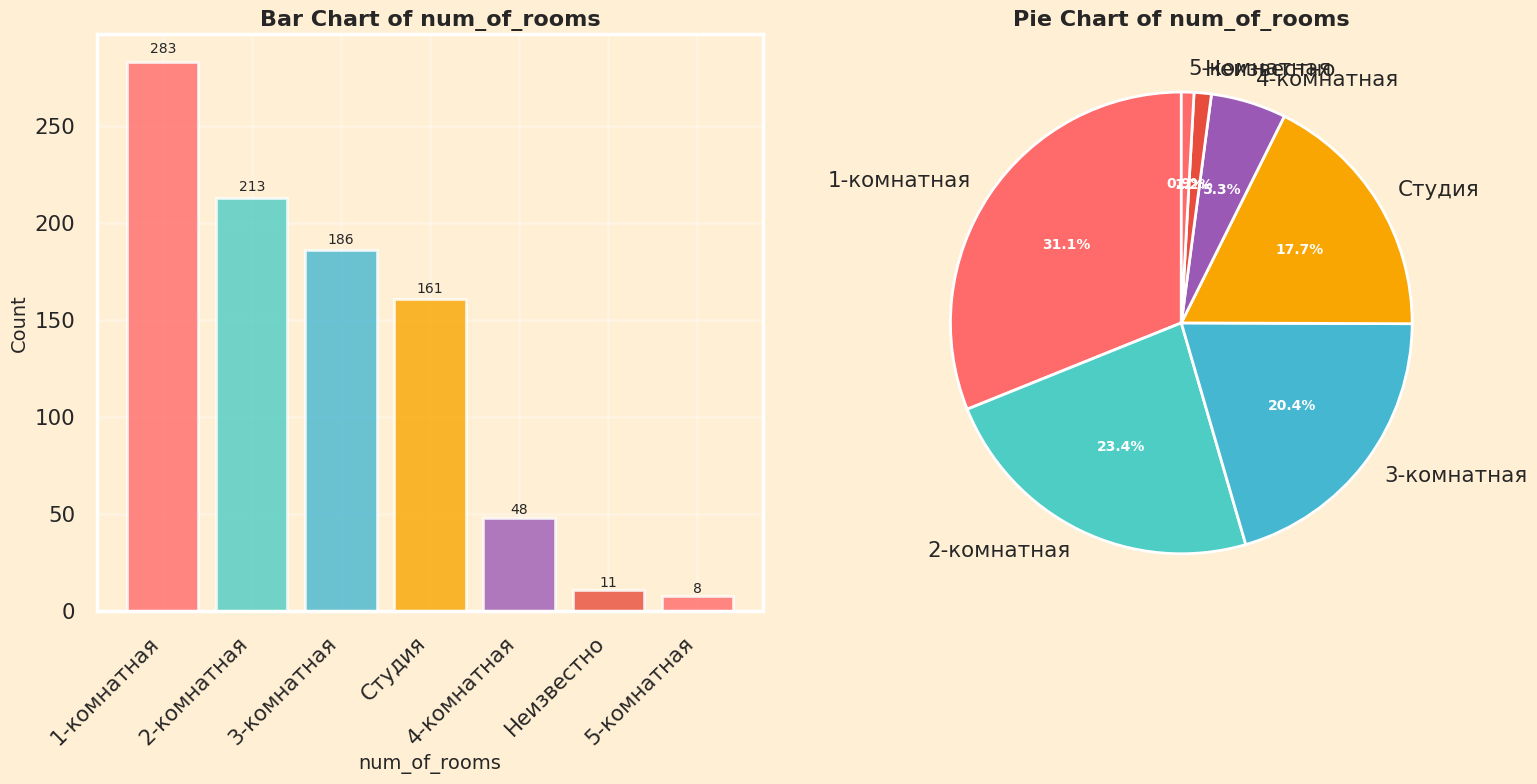

In [25]:
plot_categorical_col(df, 'num_of_rooms')

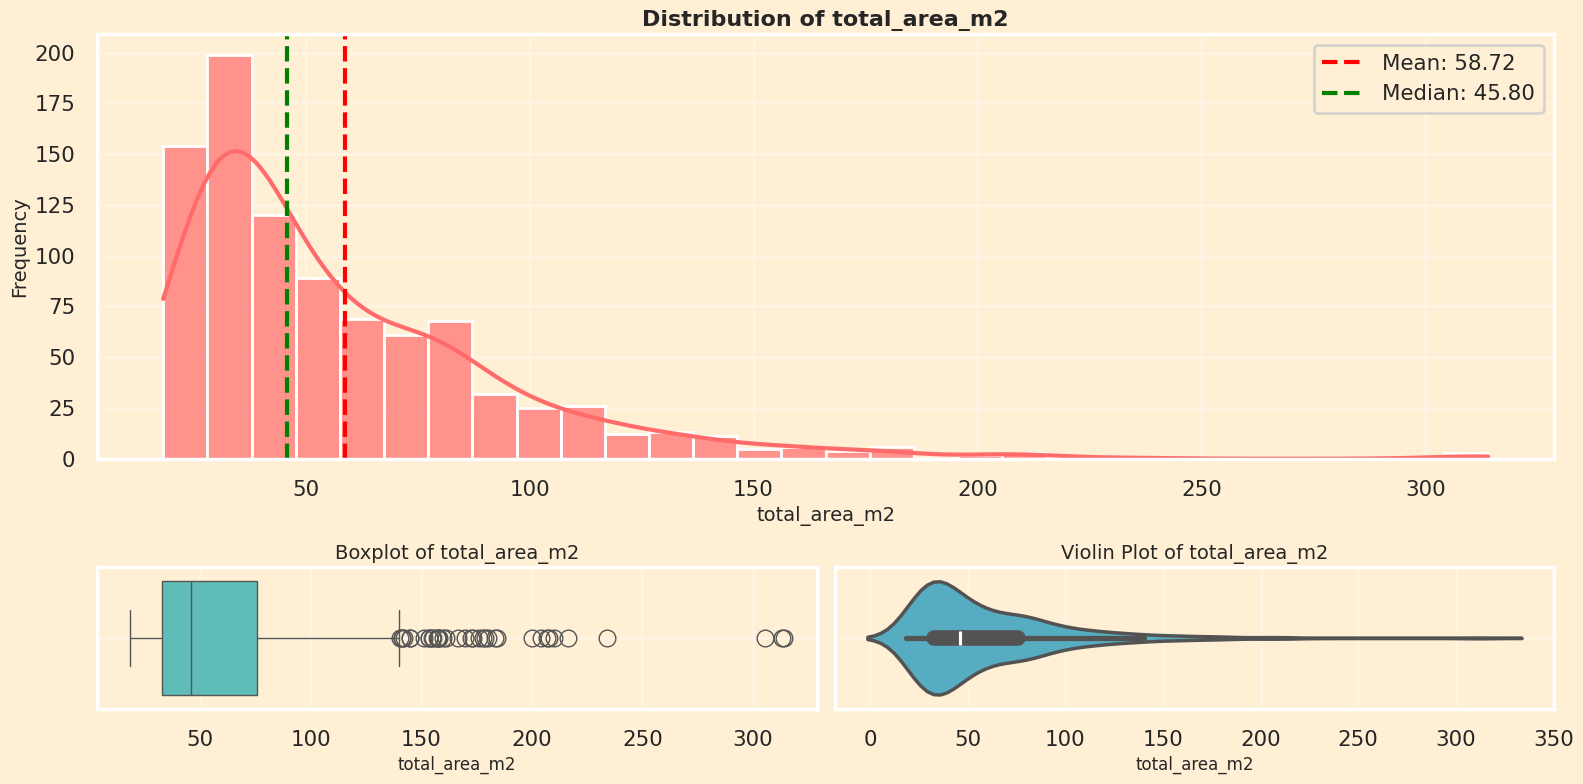

In [26]:
plot_numeric_col(df, 'total_area_m2')

In [27]:
df = df[df['total_area_m2'] <= 210]

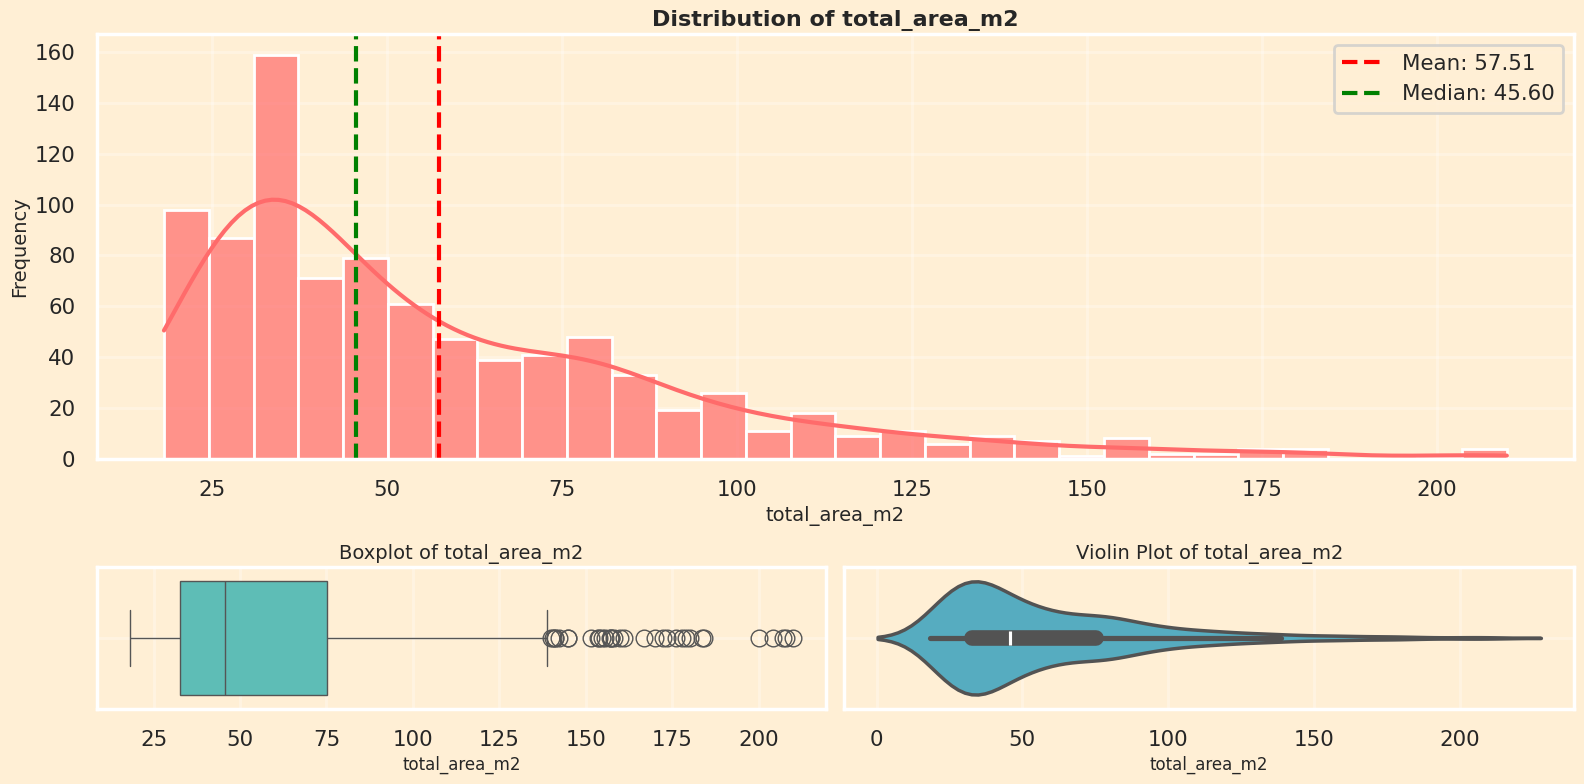

In [28]:
plot_numeric_col(df, 'total_area_m2')

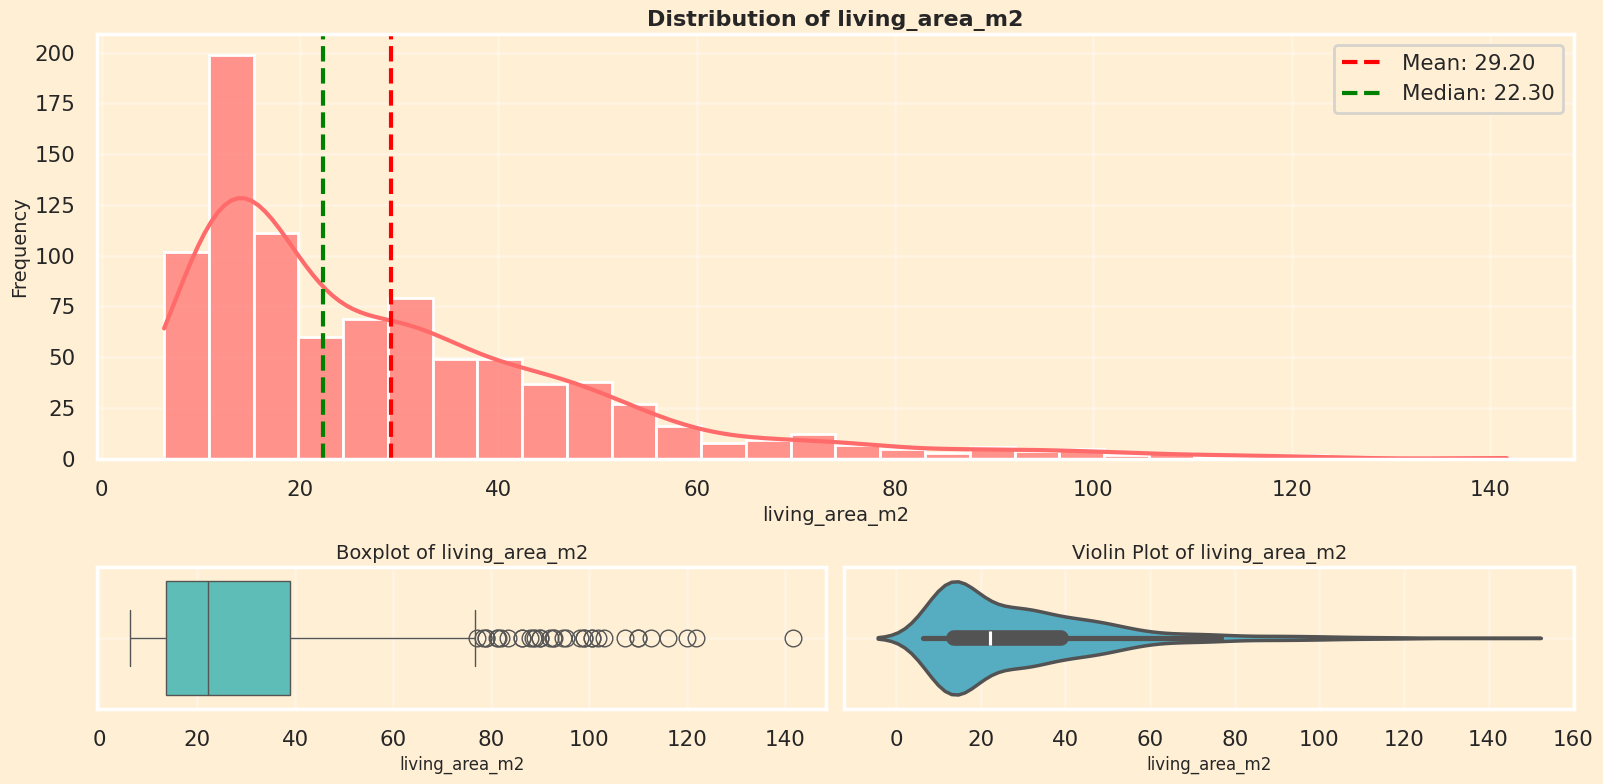

In [29]:
plot_numeric_col(df, 'living_area_m2')

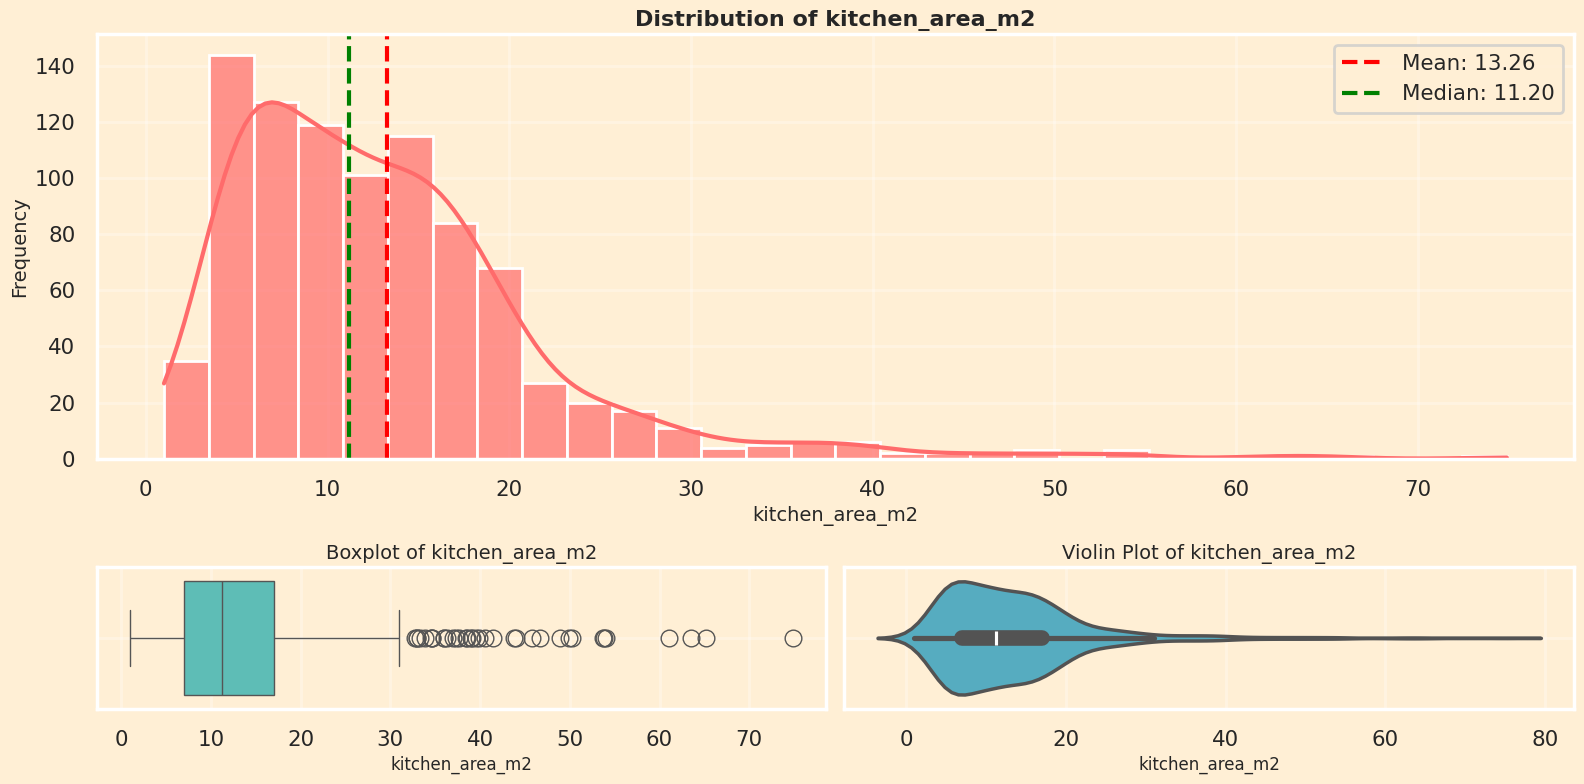

In [30]:
plot_numeric_col(df, 'kitchen_area_m2')

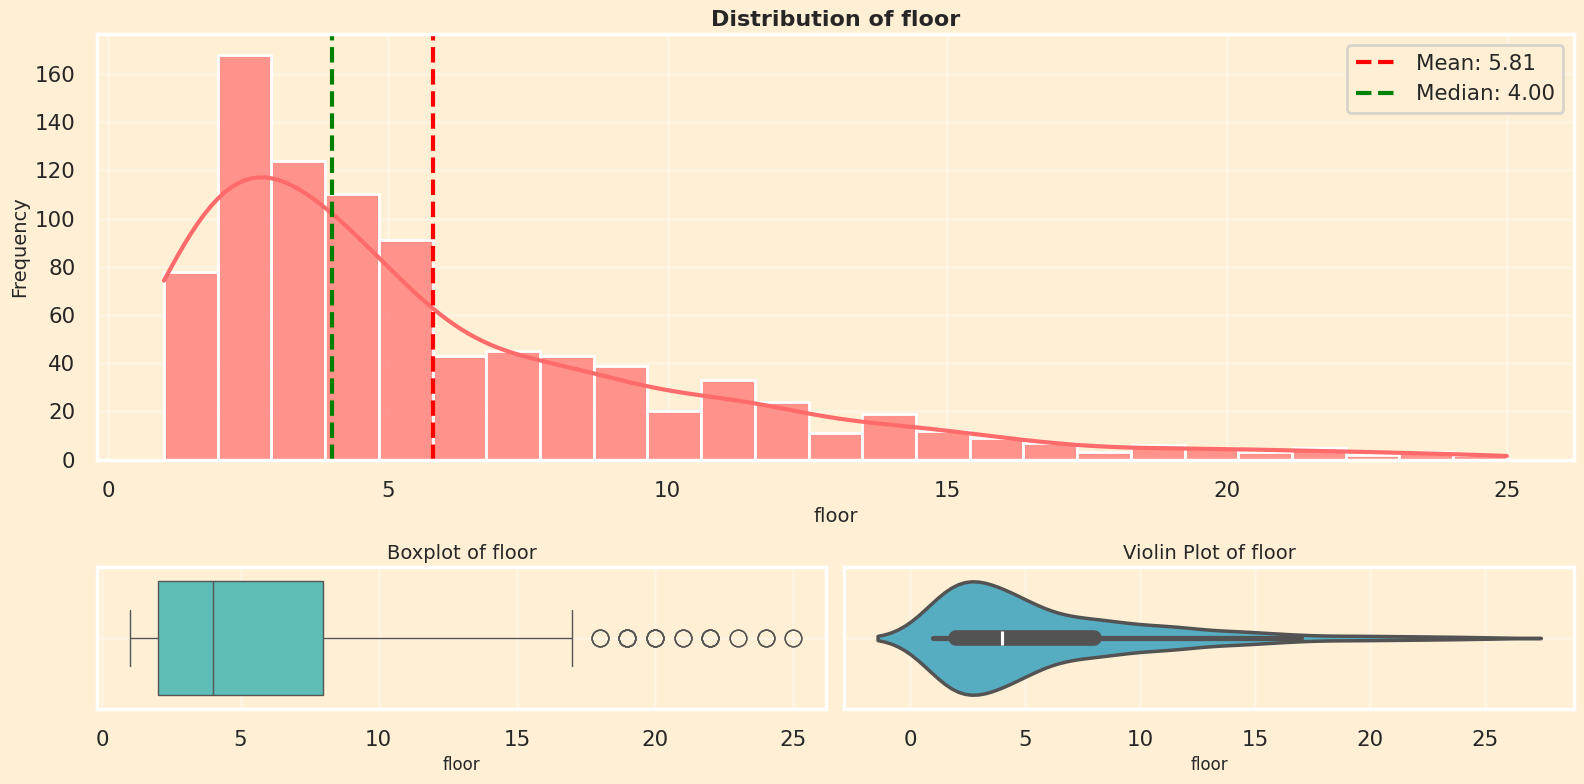

In [31]:
plot_numeric_col(df, 'floor', bins=25)

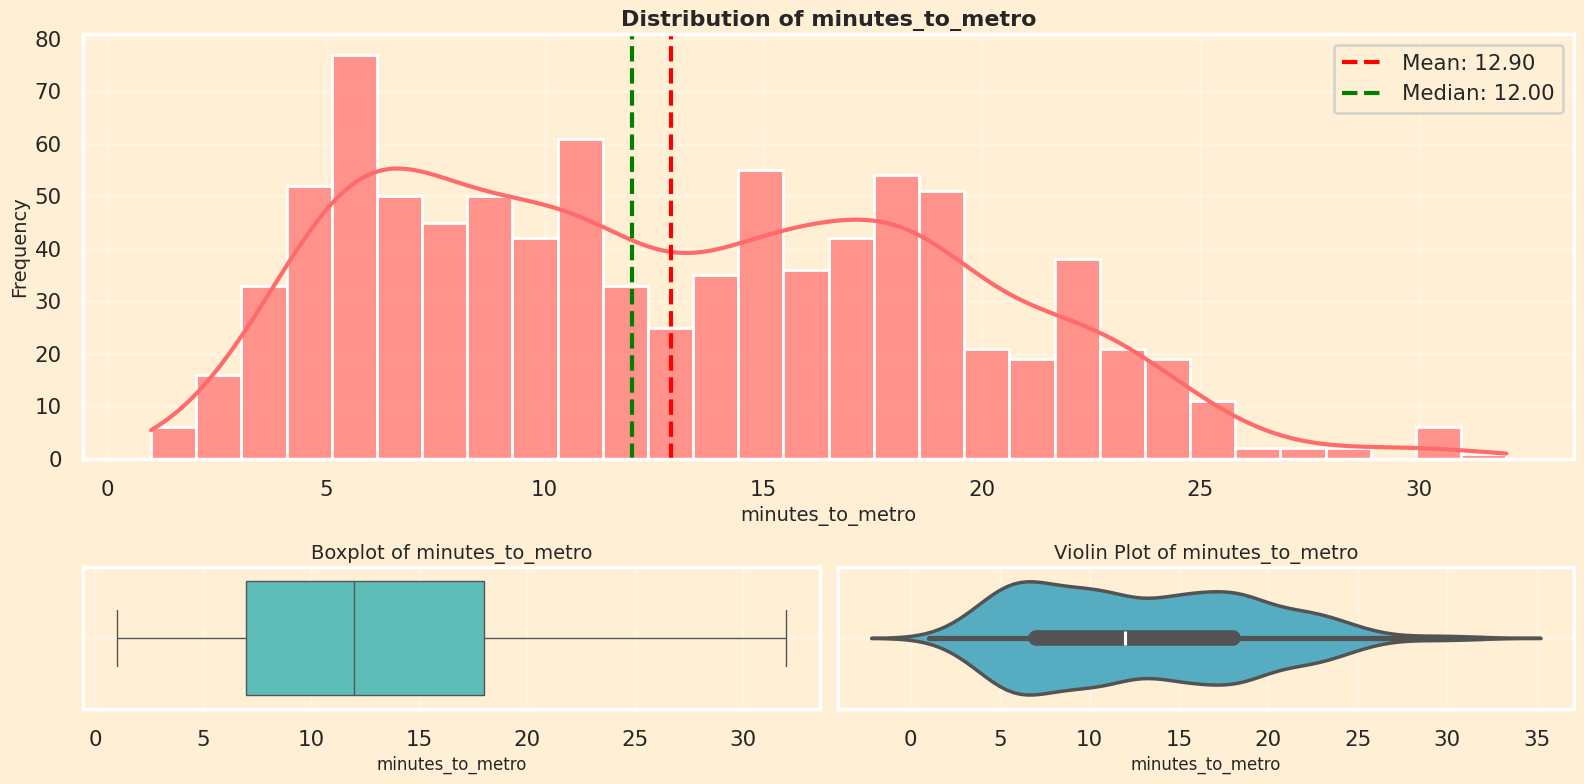

In [32]:
plot_numeric_col(df, 'minutes_to_metro')

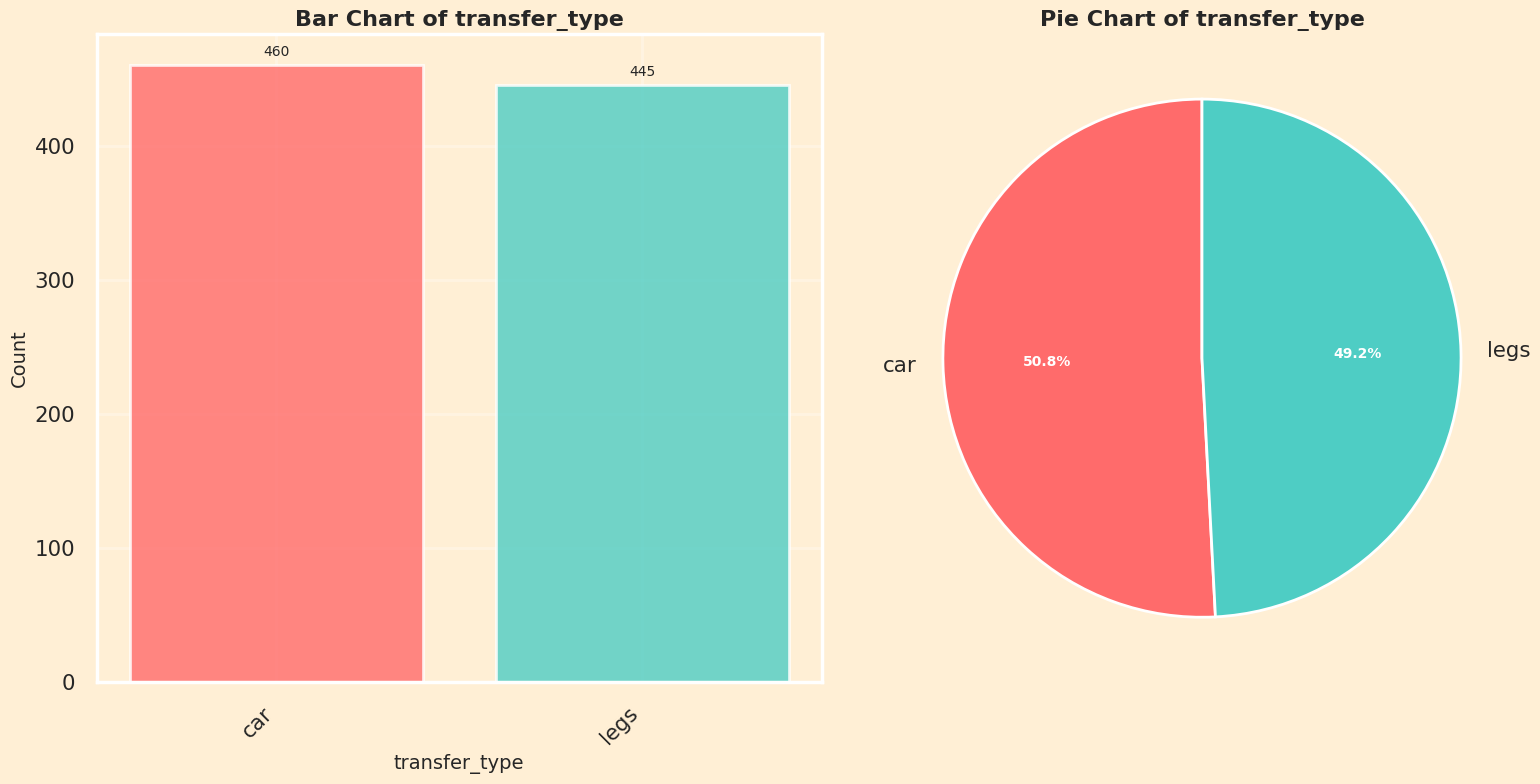

In [33]:
plot_categorical_col(df, 'transfer_type')

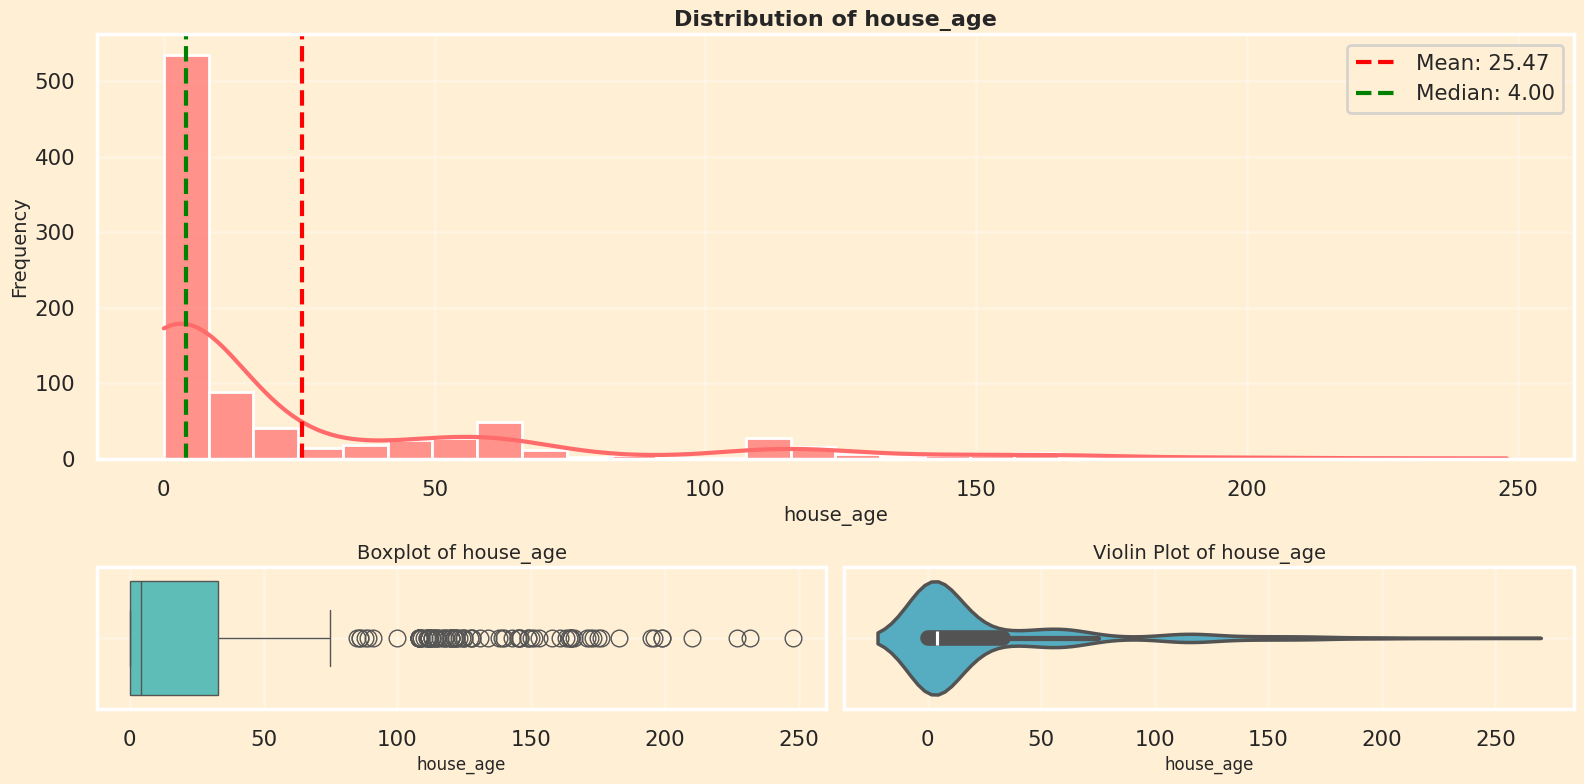

In [34]:
plot_numeric_col(df, 'house_age')

In [35]:
df = df[df['house_age'] <= 180]

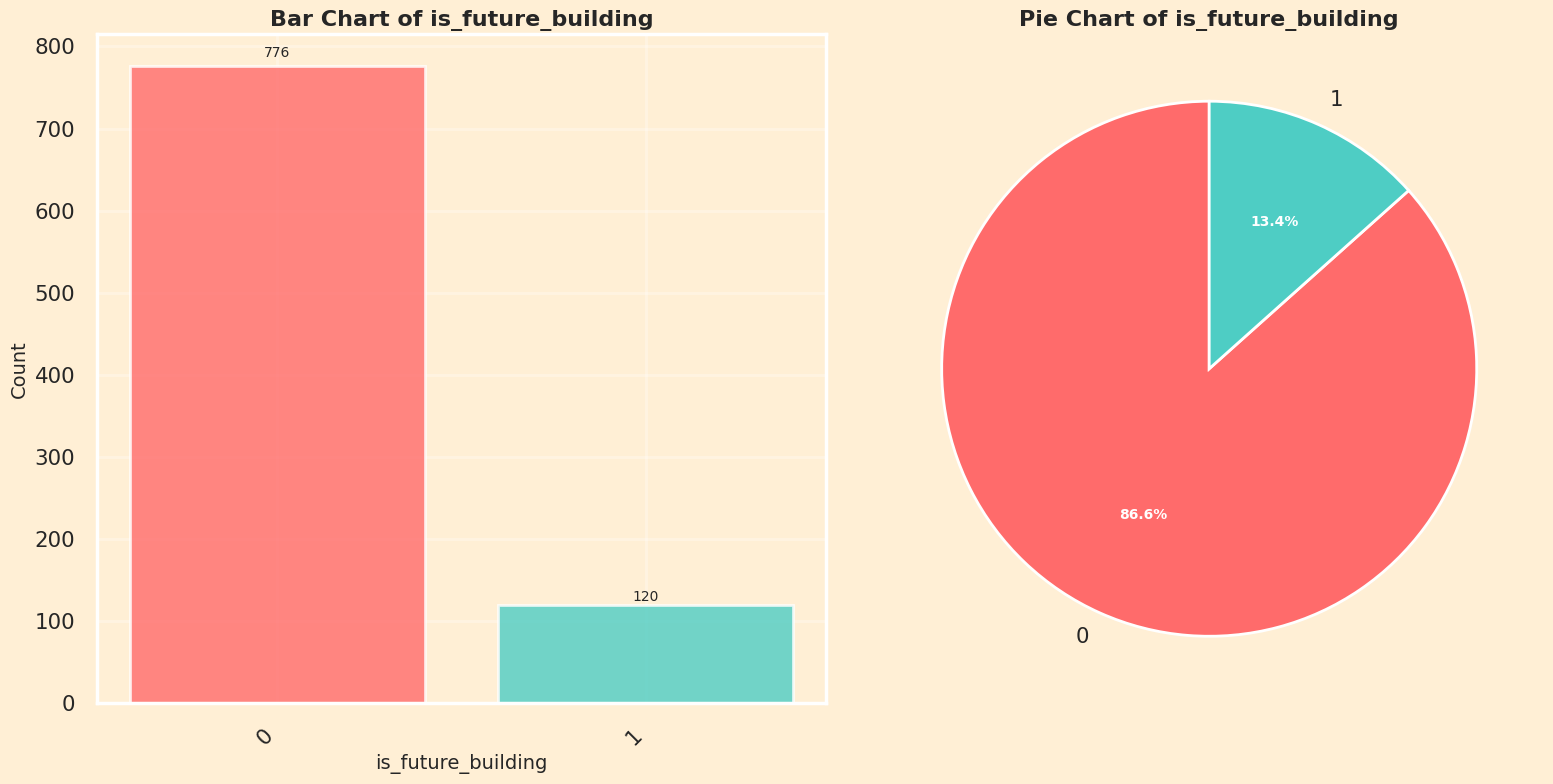

In [36]:
plot_categorical_col(df, 'is_future_building')

In [37]:
shape_after_eda = df.shape
diff = shape_before_eda[0] - shape_after_eda[0]
print(f'–í—Å–µ–≥–æ —É–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: {diff}, {diff/shape_before_eda[0]:.2%} % –æ—Ç –∏—Å—Ö–æ–¥–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞')

–í—Å–µ–≥–æ —É–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 102, 10.22% % –æ—Ç –∏—Å—Ö–æ–¥–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞


## –ö–æ—Ä—Ä–µ–ª—è—Ü–∏–æ–Ω–Ω—ã–π –∞–Ω–∞–ª–∏–∑

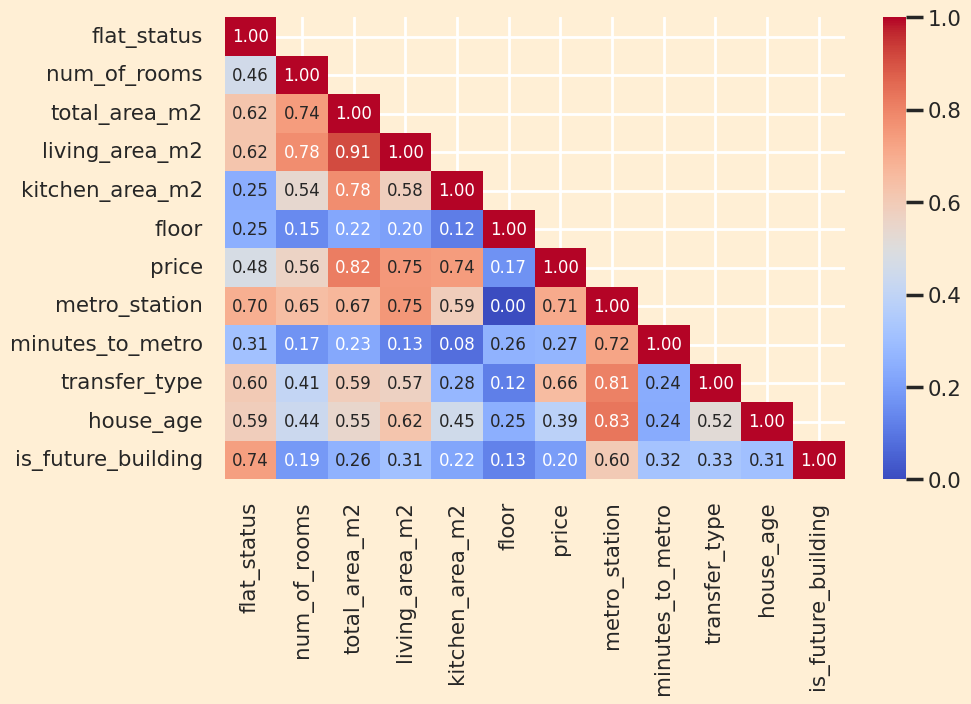

In [53]:
phik_mtx = phik_matrix(df, interval_cols=['flat_status',
                                            'total_area_m2',
                                            'living_area_m2',
                                            'kitchen_area_m2',
                                            'floor',
                                            'price',
                                            'minutes_to_metro',
                                            'house_age',
                                            'is_future_building'])
mask = np.triu(np.ones_like(phik_mtx, dtype=bool), k=1)
plt.figure(figsize=(10, 6))
sns.heatmap(phik_mtx, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=0, vmax=1)
plt.show()


## –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π

In [39]:
df.head()

flat_status num_of_rooms  total_area_m2  living_area_m2  kitchen_area_m2  \
0            1  4-–∫–æ–º–Ω–∞—Ç–Ω–∞—è         125.50            75.8             22.9   
1            1  2-–∫–æ–º–Ω–∞—Ç–Ω–∞—è          41.50            26.4              6.0   
2            0  3-–∫–æ–º–Ω–∞—Ç–Ω–∞—è          80.39            44.9             10.2   
3            1  2-–∫–æ–º–Ω–∞—Ç–Ω–∞—è          65.10            27.0             19.0   
4            1  1-–∫–æ–º–Ω–∞—Ç–Ω–∞—è          38.50            16.6             10.5   

   floor     price     metro_station  minutes_to_metro transfer_type  \
0      4  24500000        –ë–∞–ª—Ç–∏–π—Å–∫–∞—è                 5           car   
1      3   6300000        –ú–æ—Å–∫–æ–≤—Å–∫–∞—è                 6           car   
2      3  30061520  –í–∞—Å–∏–ª–µ–æ—Å—Ç—Ä–æ–≤—Å–∫–∞—è                11          legs   
3      4  11500000     –£–ª–∏—Ü–∞ –î—ã–±–µ–Ω–∫–æ                 7           car   
4     10   5599000         –î–µ–≤—è—Ç–∫–∏–Ω–æ                 6           car   

   house_age  is_future_building  
0        149                   0  
1         61                   0  
2          0                   0  
3         42                   0  
4         10                   0

In [40]:
X = df.drop('price', axis=1)
y = df['price']

In [41]:
num_cols = ['total_area_m2',
            'living_area_m2',
            'kitchen_area_m2',
            'floor',
            'minutes_to_metro',
            'house_age']
cat_cols = ['flat_status',
            'num_of_rooms',
            'metro_station',
            'transfer_type',
            'is_future_building']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
# –£–∫–∞–∂–µ–º —é–∑–µ—Ä–∞, –∫–æ—Ç–æ—Ä—ã–π –¥–µ–ª–∞–µ—Ç —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã
os.environ['USER'] = 'Mikhail Lodygin'

In [62]:
# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è MLflow
mlflow.set_tracking_uri("http://localhost:5050")
mlflow.set_experiment("Estate_Saint_Petersburg")

2025/09/02 23:49:51 INFO mlflow.tracking.fluent: Experiment with name 'Estate_Saint_Petersburg' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/477538492100122856', creation_time=1756846191458, experiment_id='477538492100122856', last_update_time=1756846191458, lifecycle_stage='active', name='Estate_Saint_Petersburg', tags={}>

In [45]:
data_preprocessor = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_cols),
     ('num', StandardScaler(), num_cols),
    ],
    remainder='passthrough'
)

In [46]:
pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [58]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [1, 2, 3],
        'models__min_samples_split': [2, 3],
    },
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [1, 2, 3],
        'models__min_samples_split': [2, 3],
    },
    {
        'models': [LGBMRegressor(verbose=-1, random_state=RANDOM_STATE)]
    },
    {
        'models': [CatBoostRegressor(verbose=-1, random_state=RANDOM_STATE)]
    }
]

In [59]:
mlflow.sklearn.autolog()

In [66]:
gs = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

In [67]:
MLFLOW_RUN_NAME = "Test 2"
with mlflow.start_run(run_name=MLFLOW_RUN_NAME) as run:
    gs.fit(X_train, y_train)
    y_pred = gs.best_estimator_.predict(X_test)

    test_rmse = root_mean_squared_error(y_test, y_pred)
    test_mae =  mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("test_r2", test_r2)

2025/09/02 23:57:16 INFO mlflow.sklearn.utils: Logging the 5 best runs, 9 runs will be omitted.


üèÉ View run Test 2 at: http://localhost:5050/#/experiments/477538492100122856/runs/7895238d064548b8b2a5547f709814cb
üß™ View experiment at: http://localhost:5050/#/experiments/477538492100122856


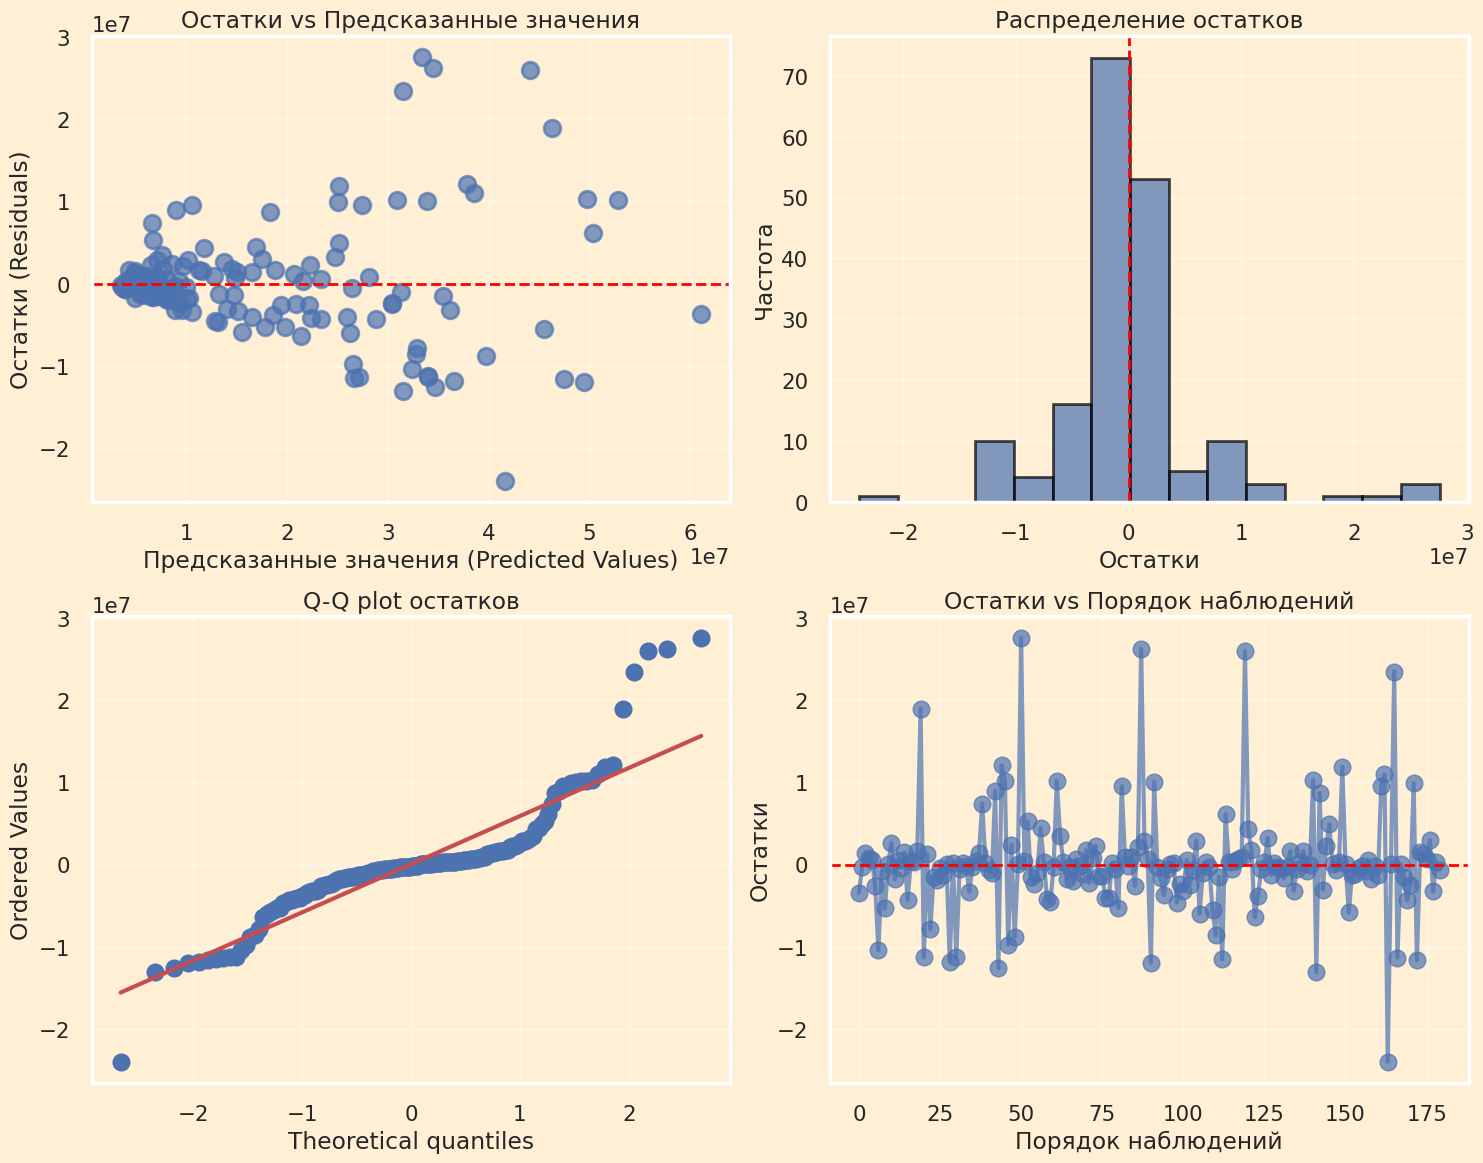

–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –æ—Å—Ç–∞—Ç–∫–æ–≤:
–°—Ä–µ–¥–Ω–µ–µ –æ—Å—Ç–∞—Ç–∫–æ–≤: 44798.1805
–°—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ: 6385680.9145
–ú–µ–¥–∏–∞–Ω–∞: -218888.9873
–ú–∏–Ω–∏–º–∞–ª—å–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ: -23922559.9941
–ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ: 27581587.9349


In [68]:
residuals = y_test - y_pred

# –°–æ–∑–¥–∞–µ–º –≥—Ä–∞—Ñ–∏–∫
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. –û—Å—Ç–∞—Ç–∫–∏ vs –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è (–°–ê–ú–´–ô –í–ê–ñ–ù–´–ô –ì–†–ê–§–ò–ö)
axes[0, 0].scatter(y_pred, residuals, alpha=0.7)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è (Predicted Values)')
axes[0, 0].set_ylabel('–û—Å—Ç–∞—Ç–∫–∏ (Residuals)')
axes[0, 0].set_title('–û—Å—Ç–∞—Ç–∫–∏ vs –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è')
axes[0, 0].grid(True, alpha=0.3)

# 2. –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –æ—Å—Ç–∞—Ç–∫–æ–≤ (–≥–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞)
axes[0, 1].hist(residuals, bins=15, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('–û—Å—Ç–∞—Ç–∫–∏')
axes[0, 1].set_ylabel('–ß–∞—Å—Ç–æ—Ç–∞')
axes[0, 1].set_title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –æ—Å—Ç–∞—Ç–∫–æ–≤')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q plot –¥–ª—è –ø—Ä–æ–≤–µ—Ä–∫–∏ –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç–∏ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –æ—Å—Ç–∞—Ç–∫–æ–≤
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q plot –æ—Å—Ç–∞—Ç–∫–æ–≤')
axes[1, 0].grid(True, alpha=0.3)

# 4. –û—Å—Ç–∞—Ç–∫–∏ vs –ü–æ—Ä—è–¥–æ–∫ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π (–¥–ª—è –ø—Ä–æ–≤–µ—Ä–∫–∏ –∞–≤—Ç–æ–∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏)
axes[1, 1].plot(range(len(residuals)), residuals, 'o-', alpha=0.7)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('–ü–æ—Ä—è–¥–æ–∫ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π')
axes[1, 1].set_ylabel('–û—Å—Ç–∞—Ç–∫–∏')
axes[1, 1].set_title('–û—Å—Ç–∞—Ç–∫–∏ vs –ü–æ—Ä—è–¥–æ–∫ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# –î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞
print("–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –æ—Å—Ç–∞—Ç–∫–æ–≤:")
print(f"–°—Ä–µ–¥–Ω–µ–µ –æ—Å—Ç–∞—Ç–∫–æ–≤: {np.mean(residuals):.4f}")
print(f"–°—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ: {np.std(residuals):.4f}")
print(f"–ú–µ–¥–∏–∞–Ω–∞: {np.median(residuals):.4f}")
print(f"–ú–∏–Ω–∏–º–∞–ª—å–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ: {np.min(residuals):.4f}")
print(f"–ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ: {np.max(residuals):.4f}")

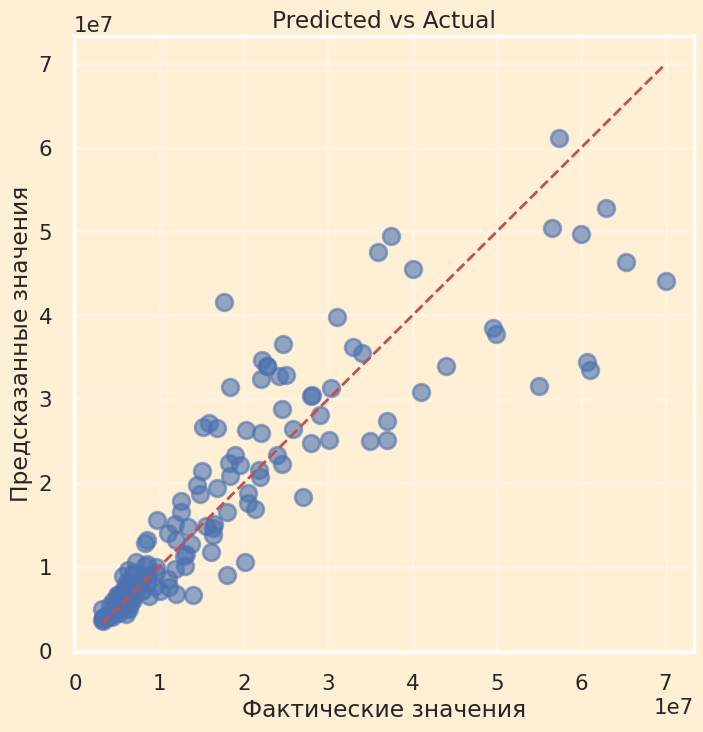

In [69]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)  # –ò–¥–µ–∞–ª—å–Ω–∞—è –ª–∏–Ω–∏—è y=x
plt.xlabel('–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.ylabel('–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è')
plt.title('Predicted vs Actual')
plt.grid(True, alpha=0.3)
plt.show()

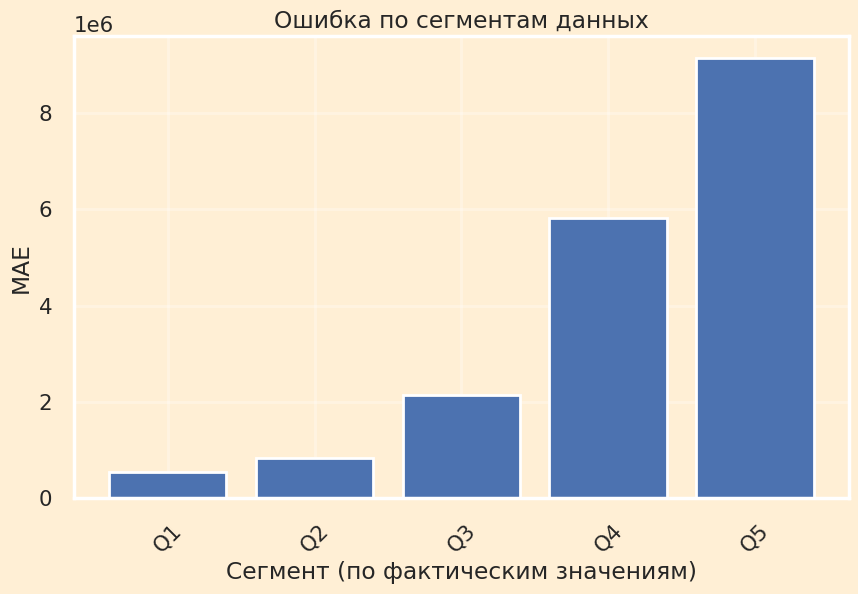

In [70]:
# –°–æ–∑–¥–∞–µ–º —Å–µ–≥–º–µ–Ω—Ç—ã –ø–æ —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏–º –∑–Ω–∞—á–µ–Ω–∏—è–º
df_results = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
df_results['segment'] = pd.qcut(df_results['actual'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

# –°—á–∏—Ç–∞–µ–º MAE –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Å–µ–≥–º–µ–Ω—Ç–∞
segment_error = df_results.groupby('segment').apply(
    lambda x: mean_absolute_error(x['actual'], x['predicted'])
).reset_index(name='MAE')

plt.figure(figsize=(10, 6))
plt.bar(segment_error['segment'].astype(str), segment_error['MAE'])
plt.xlabel('–°–µ–≥–º–µ–Ω—Ç (–ø–æ —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏–º –∑–Ω–∞—á–µ–Ω–∏—è–º)')
plt.ylabel('MAE')
plt.title('–û—à–∏–±–∫–∞ –ø–æ —Å–µ–≥–º–µ–Ω—Ç–∞–º –¥–∞–Ω–Ω—ã—Ö')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import shap

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∏—Ä—É–µ–º explainer
explainer = shap.TreeExplainer(gs.best_estimator_)
shap_values = explainer.shap_values(X_test)

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15)
plt.show()

# –ë–æ–ª–µ–µ –¥–µ—Ç–∞–ª—å–Ω—ã–π summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, max_display=15)
plt.show()